In [32]:
import nibabel
import nibabel.affines
from PIL import Image
import os
import fnmatch
import numpy as np
import ants
import scipy.io as sio
import pickle
import concurrent.futures
import pandas as pd
import glob
import xml.etree.ElementTree as ET
import xmltodict

np.set_printoptions(precision=2, suppress=True)

## File handling and loading functions

In [33]:
# Load an image into nibabel
def load_image(data_path, filename):
    
    return nibabel.load(f"{data_path}/{filename}")

# Display the middle slice of a nibabel image
def display_image(image):

    # Get image data array from image object
    image_array = np.asarray(image.dataobj)
    
    # Get middle slice
    slice = image_array[image_array.shape[0] // 2, :, :]
    
    # Scale the image such that the maximum pixel value is 255
    # Display the scaled image
    display(Image.fromarray(((slice / np.max(slice)) * 255).astype(np.uint8)))
    
    return 

# Display the middle slice of a 3d array
def display_array(array):
    
    # Get middle slice
    slice = array[array.shape[0] // 2, :, :]
    
    # Scale the image such that the maximum pixel value is 255
    # Display the scaled image
    display(Image.fromarray(((slice / np.max(slice)) * 255).astype(np.uint8)))
    
    return 

# Find files with a specific filename and return a list. Non-recursive 
def list_files_ext(data_path, extensions):

    files = [f for f in os.listdir(data_path) if f.endswith(extensions)]
        
    return files       

# Return the absolute path to all files matching a filename in a directory. Recursive
def list_files_fname(data_path, filename):
    
    matched_files = []
    
    for root, dirs, files in os.walk(data_path):
        
        for file in fnmatch.filter(files, filename):
            
            matched_files.append(os.path.join(root, file))
    
    return matched_files


## Subject class

In [34]:
class Subject:
    def __init__(self, path):
        
        self.path = path
        
        self.orig_nu = os.path.join(path, "mri/orig_nu.mgz")
        
        self.mask = os.path.join(path, "mri/mask.mgz")
        
        self.aparc = os.path.join(path, "mri/aparc.DKTatlas+aseg.deep.mgz")
        
        aligned_brain = os.path.join(path, "aligned_brain.nii")
        
        self.aligned_brain = aligned_brain if os.path.isfile(aligned_brain) else None
        
        aligned_cropped_brain = os.path.join(path, "aligned_brain_cropped.nii")
        
        self.aligned_cropped_brain = aligned_cropped_brain if os.path.isfile(aligned_cropped_brain) else None
        
        transformation = os.path.join(path, "affine_alignment.pkl")
        
        self.transformation = transformation if transformation else None
        
        xml_files = glob.glob(os.path.join(path, "*.xml"))
        
        self.xml_path = xml_files[0] if xml_files else None
        
        self.extracted_region_list = []
        
        # Load XML if file exists
        if self.xml_path:
            
            with open(self.xml_path, 'r') as file:
            
                self.xml_df = xmltodict.parse(file.read())
            
        else:
            
            self.xml_df = None

        
        # Manually assign the column headers
        header = ['ColHeaders', 'Index', 'SegId', 'NVoxels', 'Volume_mm3', 'StructName', 'normMean', 'normStdDev', 'normMin', 'normMax', 'normRange']
        
        self.aseg_stats = pd.read_csv(os.path.join(path, 'stats/aseg+DKT.stats'), delimiter='\s+', comment='#', header=None, names=header)

    def display_info(self):
        """Displays basic information about the subject"""
        print(f"Subject File Path: {self.file_path}")
        print(f"DataFrame Head:\n{self.aseg_stats.head()}")
        
# Searches data_path for subject directories and creates an object for each of them
def find_subjects(data_path):
    
    subject_list = []

    for item in os.listdir(data_path):
        
        subject_path = os.path.join(data_path, item)
        
        if os.path.isdir(subject_path):
            
            # MRI directory of subject path (checking validity)
            mri_path = os.path.join(subject_path, 'mri')
            
            # Check for MRI directory
            if os.path.isdir(mri_path):
                
                orig_file = os.path.join(mri_path, 'orig_nu.mgz')
                
                mask_file = os.path.join(mri_path, 'mask.mgz')

                # If both orig.mgz and mask.mgz exist, create object
                if os.path.isfile(orig_file) and os.path.isfile(mask_file):
                    
                    subject_list.append(Subject(subject_path))

    return subject_list

<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_44950/1312864290.py:45: SyntaxWarning: invalid escape sequence '\s'
  self.aseg_stats = pd.read_csv(os.path.join(path, 'stats/aseg+DKT.stats'), delimiter='\s+', comment='#', header=None, names=header)


## Image manipulation functions

### Brain extraction

In [35]:
# Performs brain extraction using the orig_nu.mgz and mask.mgz of the subject by multiplying the mask with the image
def extract_brain(orig_file, mask_file):
    
    # Load the image and the brain mask
    image = nibabel.load(orig_file)
    mask = nibabel.load(mask_file)
    
    # Get their image arrays
    image_array = np.asarray(image.dataobj)
    mask_array = np.asarray(mask.dataobj)
    
    # Apply the mask, the mask entries are 1 or 0
    brain_array = image_array * mask_array
    
    return brain_array

### Reference brain (global)

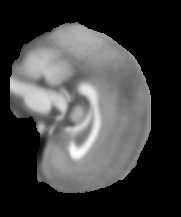

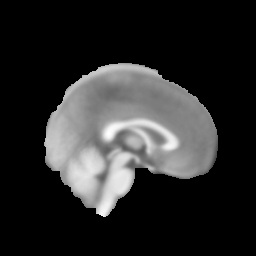

In [36]:
# NB seems that fastsrufer brain is better
reference_brain_array_mni = extract_brain("/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/icbm_avg_152_t1_tal_lin.nii", "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/icbm_avg_152_t1_tal_lin_mask.nii")

display_array(reference_brain_array_mni)

reference_brain_array_fastsurfer = extract_brain("/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/fastsurfer-processed/mri/orig_nu.mgz", "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/fastsurfer-processed/mri/mask.mgz")

display_array(reference_brain_array_fastsurfer)


### Affine alignment

In [37]:
# Function for affine registration and saving the transformation
def affine_alignment(subject_list):
        
    # Use ProcessPoolExecutor to run affine alignment in parallel
    with concurrent.futures.ProcessPoolExecutor() as executor:
        
        futures = []
        
        for subject in subject_list:

            futures.append(executor.submit(alignment, subject))
        
        for future in concurrent.futures.as_completed(futures):
            
            display_image(future.result())
            
    
    def alignment(subject):
        
        # Extract brain of subject and convert it to an ANTsPy image
        # The subject's brain is the moving image
        brain_array = extract_brain(subject.orig, subject.mask)
        
        moving_image = ants.from_numpy(brain_array)
        
        # Convert the reference brain to an ANTsPy image
        # The reference brain is already extracted
        fixed_image = ants.from_numpy(reference_brain_array_fastsurfer)
        
        # Perform registration using ANTsPy
        registration = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='AffineFast')
        
        aligned_brain_array = registration['warpedmovout'].numpy()
        
        # Load the .mat file containing the transformation
        transformation = sio.loadmat(registration['fwdtransforms'][0])
        
        # Save the transformation to a pickle file
        with open(os.path.join(subject.path, 'affine_alignment.pkl'), 'wb') as file:
            pickle.dump(transformation, file)
        
        # Make nibabel image from array
        # Identity matrix as affine transform
        aligned_image = nibabel.Nifti1Image(aligned_brain_array, np.eye(4))
        
        # Save the NiBabel image as a .nii file
        aligned_image_path = os.path.join(subject.path, 'aligned_brain.nii')
        
        nibabel.save(aligned_image, aligned_image_path)
        
        subject.aligned_brain = aligned_image_path
        
        return aligned_image

### Cropping

In [38]:
def crop_subjects(subject_list, relative_path):
    
    def bounding_box(image_array):
    
        non_zero_indices = np.nonzero(image_array)
        
        min_x, min_y, min_z = np.min(non_zero_indices[0]), np.min(non_zero_indices[1]), np.min(non_zero_indices[2])
        max_x, max_y, max_z = np.max(non_zero_indices[0]), np.max(non_zero_indices[1]), np.max(non_zero_indices[2])
        
        return (min_x, min_y, min_z, max_x, max_y, max_z)
    
    max_bbox = (np.inf, np.inf, np.inf, -np.inf, -np.inf, -np.inf)
    
    # Find maximum bbox
    for subject in subject_list:
    
        image = nibabel.load(os.path.join(subject.path, relative_path))
        
        min_x, min_y, min_z, max_x, max_y, max_z = bounding_box(image.get_fdata())
        
        global_min_x, global_min_y, global_min_z, global_max_x, global_max_y, global_max_z = max_bbox
        
        max_bbox = (
            min(global_min_x, min_x),
            min(global_min_y, min_y),
            min(global_min_z, min_z),
            max(global_max_x, max_x),
            max(global_max_y, max_y),
            max(global_max_z, max_z)
        )
    
    # Crop the images
    for subject in subject_list:
        
        image = nibabel.load(os.path.join(subject.path, relative_path))
        
        image_array = image.get_fdata()
        
        global_min_x, global_min_y, global_min_z, global_max_x, global_max_y, global_max_z = max_bbox
        
        # Crop the image array using the global bounding box
        cropped_array = image_array[
            int(global_min_x):int(global_max_x),
            int(global_min_y):int(global_max_y),
            int(global_min_z):int(global_max_z)
        ]
        
        # Create a new NiBabel image from the cropped array
        cropped_image = nibabel.Nifti1Image(cropped_array, image.affine)
        
        display_image(cropped_image)
        
        cropped_path = os.path.join(subject.path, 'aligned_brain_cropped.nii')
        
        # Overwrite the original image by saving the cropped image back to the same path
        nibabel.save(cropped_image, cropped_path)
        
        subject.aligned_cropped_brain = cropped_path

## Main code

In [39]:
subject_list = find_subjects("/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch disk/full-datasets/adni1-complete-1yr-3t")

{'subjectIdentifier': '127_S_0844', 'researchGroup': 'AD', 'subjectSex': 'F', 'subjectInfo': [{'@item': 'APOE A1', '#text': '3'}, {'@item': 'APOE A2', '#text': '3'}], 'visit': {'visitIdentifier': 'ADNI1/GO Month 6', 'assessment': [{'@name': 'MMSE', 'component': {'@name': 'MMSE Total Score', 'assessmentScore': {'@attribute': 'MMSCORE', '#text': '22.0'}}}, {'@name': 'CDR', 'component': {'@name': 'CDR Total Score', 'assessmentScore': {'@attribute': 'CDGLOBAL', '#text': '1.0'}}}, {'@name': 'Neuropsychiatric Inventory-Questionnaire (NPI-Q)', 'component': {'@name': 'Neuropsychiatric Inventory Q - Total Score', 'assessmentScore': {'@attribute': 'NPISCORE', '#text': '1.0'}}}, {'@name': 'Functional Assessment Questionnaire', 'component': {'@name': 'FAQ Total score', 'assessmentScore': {'@attribute': 'FAQTOTAL', '#text': '25.0'}}}]}, 'study': {'studyIdentifier': '8906', 'subjectAge': '85.9753', 'ageQualifier': 'Y', 'weightKg': '66.22', 'postMortem': 'F', 'series': {'seriesIdentifier': '32353', '

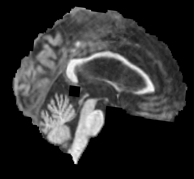

In [40]:
for subject in subject_list:
    
    research_group = subject.xml_df['idaxs']['project']['subject']['researchGroup']
    
    print(subject.xml_df['idaxs']['project']['subject'])
    
    #print(research_group)
    
    display_image(nibabel.load(subject.aligned_cropped_brain))
    
    break


<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_44950/4088886942.py:26: SyntaxWarning: invalid escape sequence '\s'
  lut = pd.read_csv(lut_path, delimiter='\s+', comment='#', header=None)
/tmp/ipykernel_44950/2471200680.py:29: RuntimeWarning: invalid value encountered in divide
  display(Image.fromarray(((slice / np.max(slice)) * 255).astype(np.uint8)))
/tmp/ipykernel_44950/2471200680.py:29: RuntimeWarning: invalid value encountered in cast
  display(Image.fromarray(((slice / np.max(slice)) * 255).astype(np.uint8)))


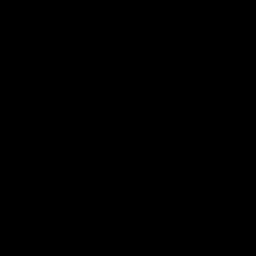

['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch disk/full-datasets/adni1-complete-1yr-3t/ADNI_127_S_0844_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070812152040976_S32353_I67261/Brain-Stem.nii', '/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch disk/full-datasets/adni1-complete-1yr-3t/ADNI_127_S_0844_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070812152040976_S32353_I67261/Left-Hippocampus_Right-Hippocampus.nii']


In [42]:
# Extracts brain regions using their number label found from freesurfer LUT
# Takes regions as a name
def extract_region(subject, values_list):
    
    aparc_array = nibabel.load(subject.aparc).get_fdata()
    
    image_array = nibabel.load(subject.orig_nu).get_fdata()
    
    # Create a mask from regions in list
    filtered_array = np.where(np.isin(aparc_array, values_list), 1, 0)
    
    # Check for empty array
    if np.all(filtered_array == 0):
        
        print("Error: region empty")
        
        return filtered_array

    
    # Extract region using mask
    extracted_region = image_array * filtered_array
    
    # Look up the name of the region for the filename
    lut_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/preprocessing/FreeSurferColorLUT.txt"
    
    lut = pd.read_csv(lut_path, delimiter='\s+', comment='#', header=None)
    
    region_names = lut[lut[0].isin(values_list)][1]

    # Save the regions as a nii file
    region_image = nibabel.Nifti1Image(extracted_region, np.eye(4))
        
    region_image_path = os.path.join(subject.path, ('_'.join(region_names) + '.nii'))
    
    nibabel.save(region_image, region_image_path)
    
    subject.extracted_region_list.append(region_image_path)
    
    return extracted_region

for subject in subject_list:
    
    display_array(extract_region(subject, [17, 53]))
    
    print(subject.extracted_region_list)
    
    break


Todo:
- Crop images to reduce the size of 3d CNN (could crop to the boundaries of the max brain after registration)
- Load XML disease label and store with image. NB could implement a class that stores various image data
- Start training NN

NB no need for intensity normalisation this is already done by freesurfer/fastsurfer